In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import cv2
import time
import numpy as np
import keras as ke
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from scipy.spatial.distance import pdist, squareform

%config Completer.use_jedi = False

import warnings
warnings.simplefilter("ignore")

## Importando Imagens do Banco

In [2]:
t1=time.time()
t2=time.time()

TAMANHO_XY = 120

# Vetores de imagens e labels
image_data = []
label_data = []

for filename in os.listdir('no/'):
    img = cv2.imread(os.path.join('no/',filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(np.array(cv2.resize(img, (TAMANHO_XY, TAMANHO_XY), interpolation=cv2.INTER_AREA)))
        label_data.append(0)
        
for filename in os.listdir('yes/'):
    img = cv2.imread(os.path.join('yes/',filename), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        image_data.append(np.array(cv2.resize(img, (TAMANHO_XY, TAMANHO_XY), interpolation=cv2.INTER_AREA)))
        label_data.append(1)

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

tempo de execução:8.83s


## Passar para 3 camadas

In [3]:
image_data = np.array([np.stack((resize(image_data[i],(TAMANHO_XY, TAMANHO_XY)),)*3, axis=-1) for i in range(0,3000)])

print(f'Shape: {image_data.shape}\t tipo: {type(image_data)}')

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

Shape: (3000, 120, 120, 3)	 tipo: <class 'numpy.ndarray'>
tempo de execução:13.22s


## Distribuir o DataSet em treino/validação e teste

In [4]:
t1=time.time()

# dados -> treino e teste
image_treino, image_teste, label_treino, label_teste = train_test_split(image_data, label_data, test_size=0.1, random_state=13)

# convertendo os labels
label_treino = np.array(label_treino) 
label_teste = np.array(label_teste)

print("\ntempo de execução:"+str(round(time.time()-t1,2))+"s")


tempo de execução:0.66s


## Extraindo as features dos dados de treinamento

In [5]:
t1=time.time()

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(TAMANHO_XY,TAMANHO_XY,3))

features_treino = np.array(base_model.predict(image_treino))
features_teste = np.array(base_model.predict(image_teste))

del image_treino
del image_teste

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")

tempo de execução:94.72s


## Treinamento das camadas densas

In [6]:
t1=time.time()

# listas vazias para armazenar resultados do k-folds
acc_per_fold=[]  
loss_per_fold=[]
espec_per_fold=[]
sens_per_fold=[]
all_models=[]
all_loss=[]
all_acc=[]
all_vloss=[]
all_vacc=[]

# Define the K-fold Cross Validator
k = 3
kfold = KFold(n_splits=k, shuffle=True)

fold_no = 0
for train, val in kfold.split(features_treino, label_treino):
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Define o modelo da rede
    model = Sequential()
    model.add(Flatten(input_shape=np.shape(features_treino[0])))
    model.add(Dropout(0.4))
    model.add(Dense(500, activation='relu'))  
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])
    
    history=model.fit(x=features_treino[train], y=label_treino[train], 
                      epochs=30, 
                      batch_size=32,
                      validation_data=(features_treino[val],label_treino[val]),
                      verbose=1)
    
    Y_pred = model(features_treino[val])
    y_pred = np.round(Y_pred)
    cmat=confusion_matrix(label_treino[val],y_pred,labels=[0,1])
    
    acuracia=np.sum(np.diag(cmat))*100/np.sum(cmat)
    sensibilidade=cmat[1,1]/(cmat[0,1]+cmat[1,1])*100
    especificidade=cmat[0,0]/(cmat[1,0]+cmat[0,0])*100
    
    acc_per_fold.append(sensibilidade)
    espec_per_fold.append(especificidade)
    sens_per_fold.append(sensibilidade)
    
    all_models.append(model)
    
    all_vloss.append(history.history["val_loss"])
    all_vacc.append(history.history["val_accuracy"])
    all_loss.append(history.history["loss"])
    all_acc.append(history.history["accuracy"])
    

    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/30
57/57 [==============================] - 9s 137ms/step - loss: 0.5251 - accuracy: 0.8600 - val_loss: 0.1555 - val_accuracy: 0.9444
Epoch 2/30
57/57 [==============================] - 7s 125ms/step - loss: 0.1648 - accuracy: 0.9500 - val_loss: 0.0887 - val_accuracy: 0.9733
Epoch 3/30
57/57 [==============================] - 7s 125ms/step - loss: 0.0905 - accuracy: 0.9678 - val_loss: 0.0794 - val_accuracy: 0.9778
Epoch 4/30
57/57 [==============================] - 7s 125ms/step - loss: 0.0600 - accuracy: 0.9761 - val_loss: 0.0927 - val_accuracy: 0.9789
Epoch 5/30
57/57 [==============================] - 7s 122ms/step - loss: 0.0569 - accuracy: 0.9811 - val_loss: 0.0845 - val_accuracy: 0.9822
Epoch 6/30
57/57 [==============================] - 7s 126ms/step - loss: 0.0316 - accuracy: 0.9889 - val_loss: 0.0781 - val_accuracy: 0.9811
Epoch 7/30
57/57 [==============================] -

57/57 [==============================] - 7s 120ms/step - loss: 0.0139 - accuracy: 0.9950 - val_loss: 0.1330 - val_accuracy: 0.9767
Epoch 28/30
57/57 [==============================] - 7s 117ms/step - loss: 0.0207 - accuracy: 0.9917 - val_loss: 0.1778 - val_accuracy: 0.9744
Epoch 29/30
57/57 [==============================] - 7s 117ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.1178 - val_accuracy: 0.9789
Epoch 30/30
57/57 [==============================] - 7s 117ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.1073 - val_accuracy: 0.9800
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/30
57/57 [==============================] - 7s 116ms/step - loss: 0.6613 - accuracy: 0.8372 - val_loss: 0.1276 - val_accuracy: 0.9622
Epoch 2/30
57/57 [==============================] - 6s 108ms/step - loss: 0.1821 - accuracy: 0.9500 - val_loss: 0.0999 - val_accuracy: 0.9689
Epoch 3/30
57/57 [==============================] - 6s 107m

,Acurácia,Sensibilidade,Especificidade
0,98.878924,98.878924,97.356828
1,98.910675,98.910675,97.052154
2,99.294118,99.294118,97.052632


=== média ===
Acurácia          99.027906
Sensibilidade     99.027906
Especificidade    97.153871
dtype: float64
  
=== variância ===
Acurácia          0.035602
Sensibilidade     0.035602
Especificidade    0.020596
dtype: float64
=== min ===
Acurácia          98.878924
Sensibilidade     98.878924
Especificidade    97.052154
dtype: float64
  
=== max ===
Acurácia          99.294118
Sensibilidade     99.294118
Especificidade    97.356828
dtype: float64


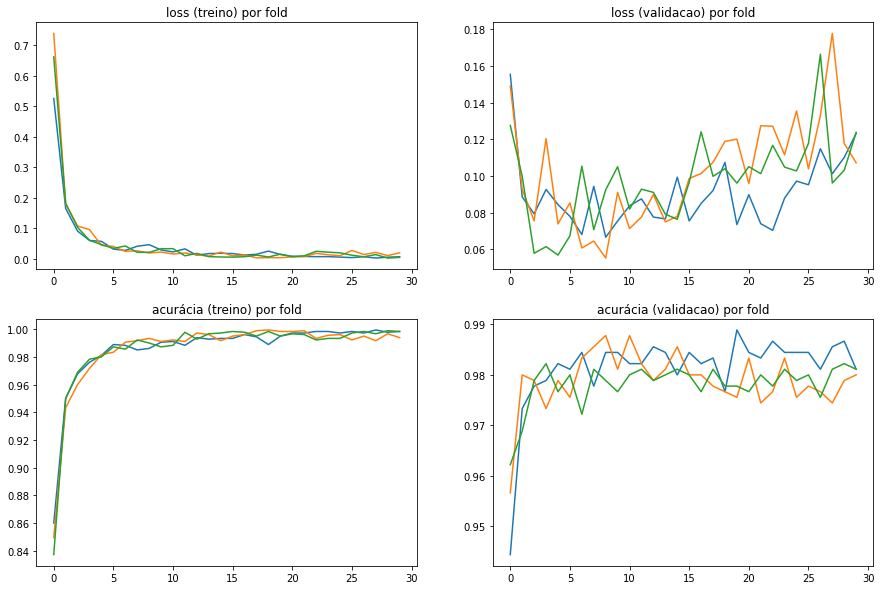

In [7]:
results = pd.DataFrame( {'Acurácia':acc_per_fold, 'Sensibilidade': sens_per_fold, 'Especificidade': espec_per_fold})
display(results)

print('=== média ===')
print(np.mean(results))
print('  ')
print('=== variância ===')
print(np.var(results))
print('=== min ===')
print(np.min(results))
print('  ')
print('=== max ===')
print(np.max(results))


plt.figure(figsize=(15,10))
for i in range(0,k):
    plt.subplot(2,2,1)
    plt.plot(all_loss[i])
    plt.title('loss (treino) por fold')
    plt.subplot(2,2,2)
    plt.plot(all_vloss[i])
    plt.title('loss (validacao) por fold')
    plt.subplot(2,2,3)
    plt.plot(all_acc[i])
    plt.title('acurácia (treino) por fold')
    plt.subplot(2,2,4)
    plt.plot(all_vacc[i])
    plt.title('acurácia (validacao) por fold')

In [8]:
t1=time.time()

predicted_classes = model.predict(features_teste)
predicted_classes = np.round(predicted_classes)

cmat = confusion_matrix(label_teste, predicted_classes)

cmat_df = pd.DataFrame(cmat,
                     index = ['0','1'], 
                     columns = ['0','1'])

target_names = ["Class {}".format(i) for i in range(2)]

print(classification_report(label_teste, predicted_classes, target_names=target_names))

# Definição das medidas de acurácia, sensibilidade e especificidade
acuracia = np.sum(np.diag(cmat))*100/np.sum(cmat)
sensibilidade = cmat_df.iloc[1][1]/(cmat_df.iloc[0][1]+cmat_df.iloc[1][1])*100
especificidade = cmat_df.iloc[0][0]/(cmat_df.iloc[1][0]+cmat_df.iloc[0][0])*100

print(f'Acurácia: {round(acuracia, 2)}%\nSensibilidade: {round(sensibilidade, 2)}%\nEspecificidade: {round(especificidade, 2)}%')

print("\ntempo de execução:"+str(round(time.time()-t1,2))+"s")

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99       156
     Class 1       1.00      0.98      0.99       144

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Acurácia: 99.0%
Sensibilidade: 100.0%
Especificidade: 98.11%

tempo de execução:0.2s


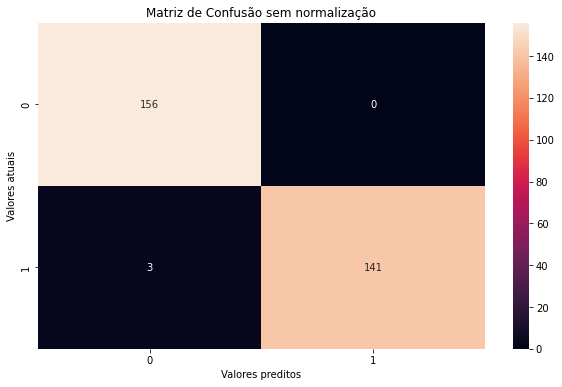

tempo de execução:0.19s
tempo de execução TOTAL:12.5Min


In [9]:
t1=time.time()

#Plotando:
plt.figure(figsize=(10,6))
sns.heatmap(cmat_df, annot=True,fmt="d")
plt.title('Matriz de Confusão sem normalização')
plt.ylabel('Valores atuais')
plt.xlabel('Valores preditos')
plt.show()

print("tempo de execução:"+str(round(time.time()-t1,2))+"s")
print("tempo de execução TOTAL:"+str(round((time.time()-t2)/60,2))+"Min")